In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import seaborn as sns
from meteostat import Point, Daily

In [2]:
#Date
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2024, 6, 26)

In [3]:
#Download cocoa commodity price
cocoa = yf.download('CC', start_date, end_date)
cocoa.describe()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1.379000e+03
mean,27.378588,27.911859,26.849979,27.375830,25.010780,1.787754e+06
std,7.670240,7.724519,7.630264,7.681499,7.501464,1.405149e+06
min,7.560000,7.940000,7.020000,7.260000,6.194838,2.750000e+05
25%,22.500000,22.929999,22.094000,22.450000,19.209462,9.967000e+05
50%,28.850000,29.260000,28.385000,28.840000,27.150000,1.388200e+06
75%,33.035000,33.684999,32.608500,33.099998,30.543677,2.164100e+06
max,44.230000,44.946999,43.605000,44.790001,41.958996,2.741020e+07


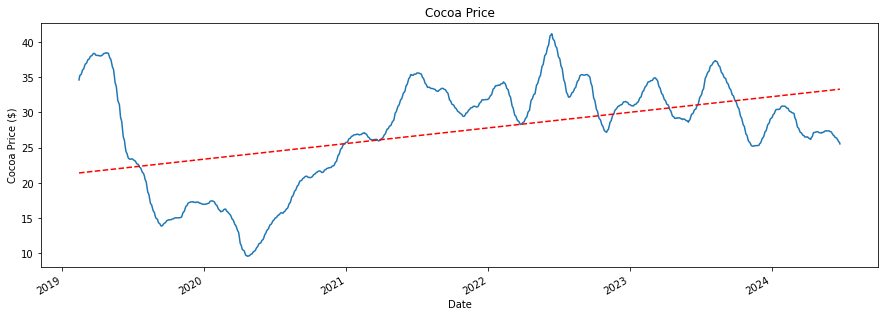

In [4]:
#Plot cocoa commodity price 30day avg
cocoa['Close: 30 Mean'] = cocoa['Close'].rolling(window=30).mean()
cocoa_nona = cocoa.dropna(subset=['Close: 30 Mean'])
cocoa_numeric_index = (cocoa_nona.index - cocoa_nona.index[0]).days
trend = np.polyfit(cocoa_numeric_index, cocoa_nona['Close: 30 Mean'], 1)
trendline = np.poly1d(trend)
cocoa['Close: 30 Mean'].plot(figsize=(15,5))
plt.plot(cocoa_nona.index, trendline(cocoa_numeric_index), 'r--')
plt.title('Cocoa Price')
plt.xlabel('Date')
plt.ylabel('Cocoa Price ($)')
plt.show()

Price has signifcantly decreased and stayed low from 2019 to 2021, then from the start of 2021 price has gone back up. Few reasons why the price was low:
* **Increased Production**: There was an increase in cocoa production during this period, particularly from major cocoa-producing countries like Côte d'Ivoire and Ghana. Favorable weather conditions and agricultural policies aimed at boosting production contributed to this increase
* **Redcue in demand**: The COVID-19 pandemic led to reduced demand for chocolate and cocoa products due to lockdowns and economic slowdowns. This decrease in demand contributed to lower prices.
* **US Currency**: Exchange rate fluctuations, especially the strength of the US dollar, impacted the prices. A stronger dollar makes commodities priced in dollars more expensive for holders of other currencies, potentially reducing demand.

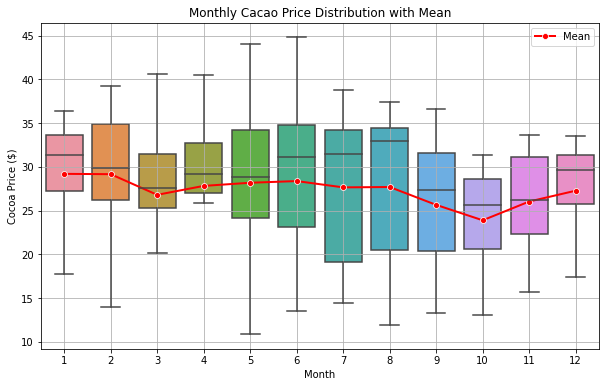

In [5]:
cocoa['Month'] = cocoa.index.month
avg_month_price = cocoa.groupby('Month')['Close'].mean().reset_index()

#Plot boxplot for each month 
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='Close', data=cocoa, showfliers=False)
sns.lineplot(x=avg_month_price['Month'] - 1, y=avg_month_price['Close'], marker='o', color='red', linestyle='-', linewidth=2, label='Mean')
plt.title('Monthly Cacao Price Distribution with Mean')
plt.xlabel('Month')
plt.ylabel('Cocoa Price ($)')
plt.grid(True)

In [6]:
#Using meteostat weather data will be imported
weather_data = {}

In [7]:
#Create point of most well-known coca porudcing regions within top cocas producing countries  
cocoa_regions = {
    'san_pedro_ivory_coast': Point(4.7485, -6.6363),
    'kumasi_ghana': Point(6.6666, -1.6163),
    'los_rios_ecuador': Point(-1.0493, -79.6167),
    'buea_cameroon': Point(4.1550, 9.2313),
    'bahia_brazil': Point(-14.7935, -39.0460),
    'san_martin_peru': Point(-6.5000, -76.3667)
}

In [8]:
for region_name, region_point in cocoa_regions.items():
    region_data = Daily(region_point, start_date, end_date)
    region_data = region_data.fetch()
    weather_data[region_name] = region_data

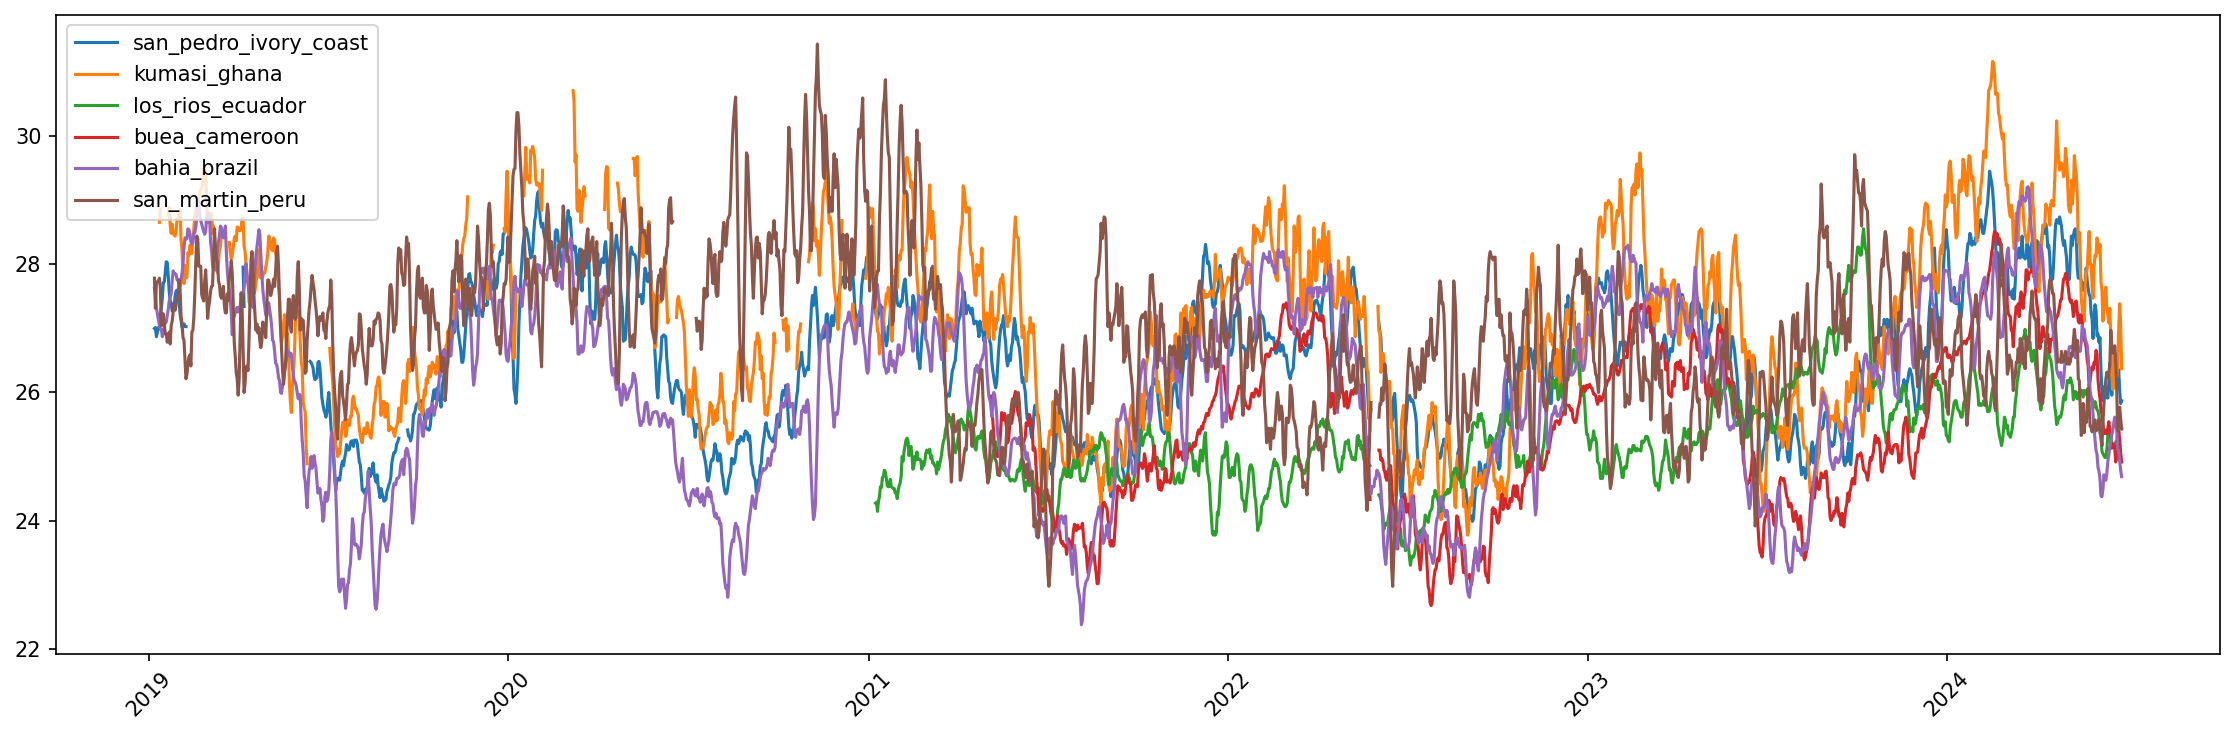

In [9]:
#Plor temperature (although not much can be known from the graph itself)
fig,ax = plt.subplots(dpi=150, figsize=(15,5))

for region_name, data in weather_data.items():
    rolling_mean = data['tavg'].rolling(window=7).mean()
    ax.plot(data.index, rolling_mean, label=region_name)

ax.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

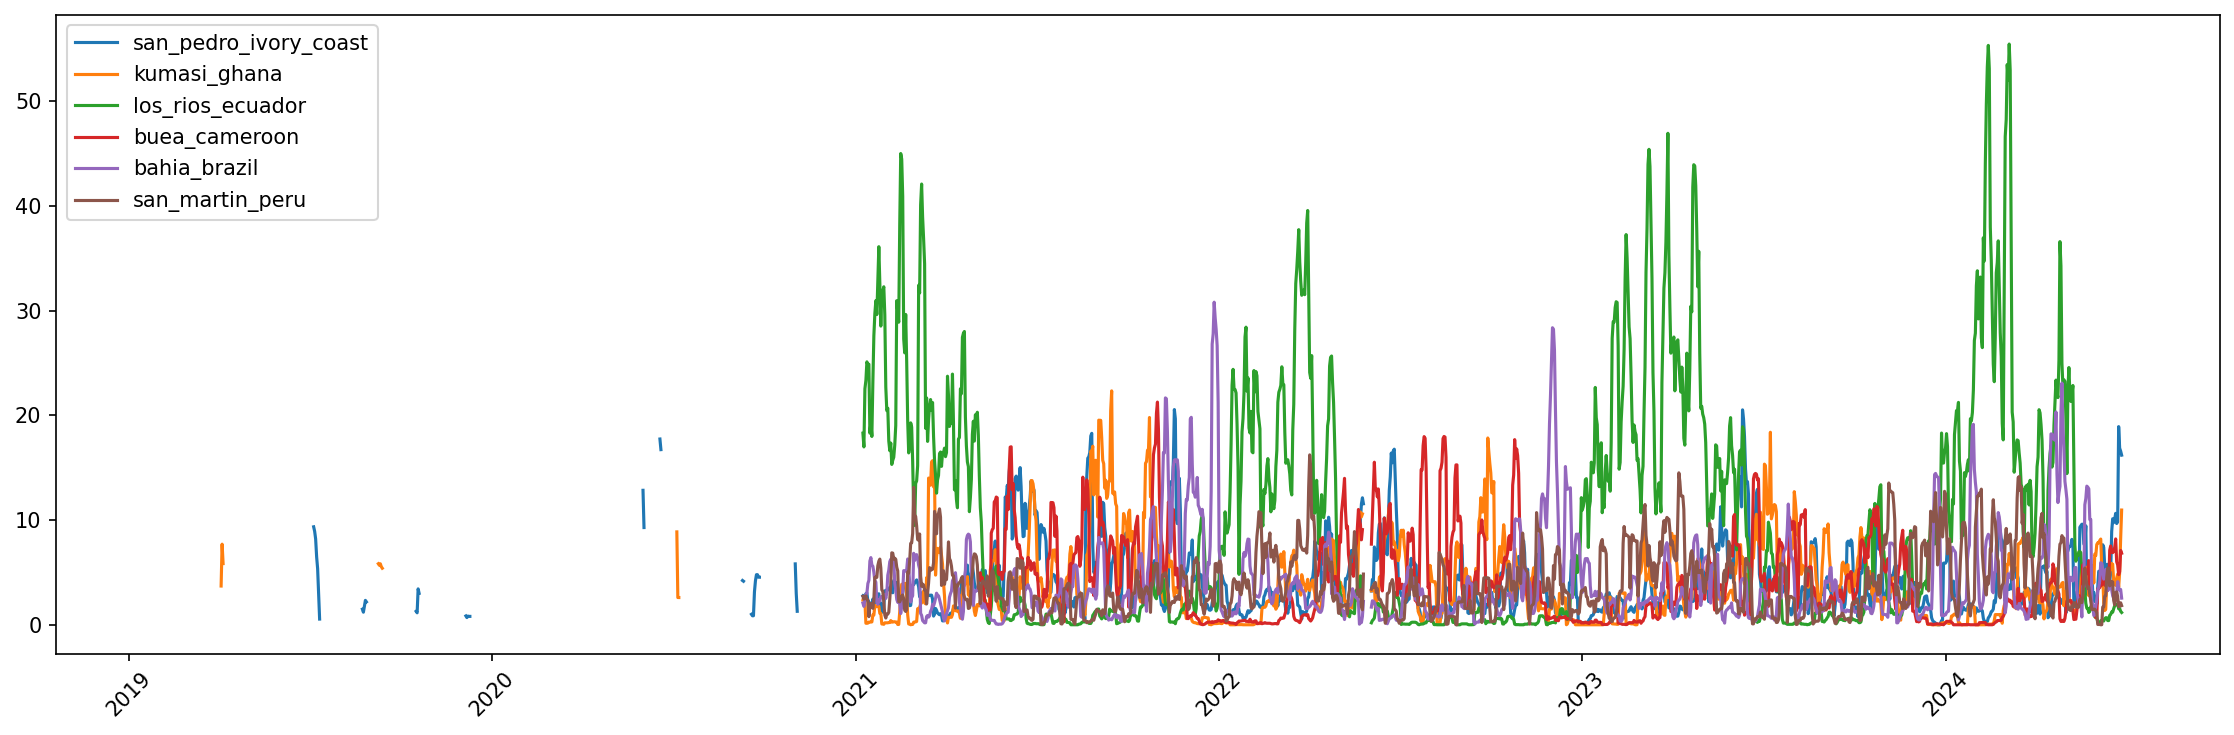

In [10]:
#Plot for percipitation data
fig,ax = plt.subplots(dpi=150, figsize=(15,5))

for region_name, data in weather_data.items():
    rolling_mean = data['prcp'].rolling(window=7).mean()
    ax.plot(data.index, rolling_mean, label=region_name)

ax.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I personally, think the percipitation data would be more important in predicting the price of cocoa commodity but with a majority of data in 2019 to 2021, when price was low, are 'NaN', it might be hard to clearly determine it. 

### Understanding different variables' relationship to  cocoa commodity price

In [11]:
import statsmodels.api as sm

In [12]:
# Combine Temperature Data
all_temps = pd.concat([df['tavg'] for df in weather_data.values()], axis=1)
overall_avg_temp = all_temps.mean(axis=1)
combined_df = pd.merge(overall_avg_temp.to_frame(name='overall_tavg'), cocoa['Close'], left_index=True, right_index=True)

In [13]:
# Combine Percipitation Data
all_prcp = pd.concat([df['prcp'] for df in weather_data.values()], axis=1)
overall_avg_p = all_prcp.mean(axis=1)
combined_df = pd.merge(overall_avg_p.to_frame(name='overall_pavg'), combined_df, left_index=True, right_index=True)

In [14]:
# US Dollar Index Data
us_fx = yf.download('DX-Y.NYB', start=start_date, end=end_date)['Close']
us_fx.name = 'US_Dollar_Index'
combined_df = pd.merge(combined_df, us_fx, left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


In [15]:
# Download Sugar Price Data
sugar = yf.download('SB=F', start=start_date, end=end_date)['Close']
sugar.name = 'Sugar_Price'
combined_df = pd.merge(combined_df, sugar, left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


In [16]:
combined_df.head()

,overall_pavg,overall_tavg,Close,US_Dollar_Index,Sugar_Price
2019-01-02,NaN,27.125,29.320000,96.820000,11.93
2019-01-03,1.0,27.320,28.799999,96.309998,11.69
2019-01-04,NaN,27.650,31.070000,96.190002,11.93
2019-01-07,41.9,27.780,31.879999,95.709999,12.65
2019-01-08,7.5,26.640,33.189999,95.900002,12.76


In [17]:
#Check 'nan'
combined_df.isna().sum()

overall_pavg       136
overall_tavg         0
Close                0
US_Dollar_Index      0
Sugar_Price          0
dtype: int64

There are a few 'nan' values and replacing them with a zero would mean there was no percipiation and really impact my model, hence I have decided to drop them for now.

In [18]:
combined_df = combined_df.dropna()

In [19]:
# Standardize the predictors
X_standardized = (combined_df[['overall_tavg', 'overall_pavg', 'US_Dollar_Index', 'Sugar_Price']] - combined_df[['overall_tavg', 'overall_pavg', 'US_Dollar_Index', 'Sugar_Price']].mean()) / combined_df[['overall_tavg', 'overall_pavg', 'US_Dollar_Index', 'Sugar_Price']].std()
Y= combined_df['Close']

# Add a constant term
X_standardized = sm.add_constant(X_standardized)

# Fit the regression model using standardized predictors
model = sm.OLS(Y, X_standardized).fit()

# Print the summary of the standardized model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     144.8
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.33e-101
Time:                        10:21:44   Log-Likelihood:                -3986.8
No. Observations:                1243   AIC:                             7984.
Df Residuals:                    1238   BIC:                             8009.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.9619      0.170    1

* **R-squared**: The R-squared value is 0.319, indicating that approximately 32% of the variance in cocoa prices ("Close") can be explained by the model. This suggests a moderate level of explanatory power.
* **F-statistic**: The F-statistic is 144.8 with a very low p-value (1.33e-101), indicating that the overall model is statistically significant and the predictors combined have a significant effect on cocoa price
* **overall_tavg**: The coefficient is -1.2667, with a t-statistic of -7.368 and a p-value of 0.000. This indicates that temperature (overall_tavg) has a statistically significant negative impact on cocoa prices (Close). Specifically, for each unit increase in temperature, cocoa prices decrease by approximately 1.2667 units, holding other variables constant.

* **overall_pavg**: The coefficient is 0.0834, with a t-statistic of 0.488 and a p-value of 0.626. The high p-value suggests that there is no statistically significant relationship between precipitation (overall_pavg) and cocoa prices (Close) in this model. The coefficient is positive, but the lack of significance indicates that changes in precipitation do not reliably predict changes in cocoa prices.

* **US_Dollar_Index**: The coefficient is -1.1359, with a t-statistic of -5.862 and a p-value of 0.000. This suggests that the US Dollar Index (US_Dollar_Index) has a statistically significant negative impact on cocoa prices. A stronger US dollar is associated with a decrease in cocoa prices by about 1.1359 units, holding other variables constant.

* **Sugar_Price**: The coefficient is 4.1693, with a t-statistic of 21.419 and a p-value of 0.000. This indicates a strong positive relationship between sugar prices (Sugar_Price) and cocoa prices (Close). For each unit increase in sugar price, cocoa prices increase by approximately 4.1693 units, holding other variables constant.

### Conclusion: 
Temperature and the US Dollar Index appear to be significant predictors of cocoa prices in this model, with both variables showing statistically significant negative impacts on cocoa prices. Precipitation, however, does not appear to have a significant impact on cocoa prices in this analysis, which is probably due to the incompleteness of the data. Finally, the Sugar Price shows a strong positive relationship with cocoa prices, indicating that higher sugar prices are associated with higher cocoa prices. This was not what I expected as I thought they were complementary goods and hence with have a negative relationship. My sepculation is that this may be due to price elasticity of sugar or market condition (temperature, weather, political issues) that have the same impact on both goods and so the price tends to move in the same direction. 

In [20]:
# Drop 'overall_pavg' column
combined_df = combined_df.drop(columns=['overall_pavg'])

In [21]:
combined_df.to_csv('cocoa_combined.csv', index=False)